This is an example IPython notebook describing how the optimizer package is used.

## Preparation

The HYSYS file should be loaded first. For example, in this case we will optimize for a simple distillation column with two feeds (a solvent stream and a feed stream).

<img src="images/hysyscase.PNG" width="20%" style="display: block;margin-left: auto;margin-right: auto;" />

Before the optimizer can be used, some settings in HYSYS has to be changed, and some things have to be added to the HYSYS case file itself.

1. HYSYS errors and warnings should be set to be output to the trace window, as any error windows would stop HYSYS from receiving any more input.
 
2. Any HYSYS operation's solver should be set to a reasonable iteration limit or each iteration would take an excessive amount of time. A recommended value is **100**. Usually, the solver is originally set to take up to 1000 or 10000 iterations. If an operation is unable to converge, the solver would take minutes or more to finish each iteration and the optimization process will be infeasibly long.
 

The optimizer itself targets a spreadsheet which contains the controls to the HYSYS flowsheet and its variables. It must be structured in the following format:

<table style="width:50%">
  <tr>
    <td>&lt;Imported Variable&gt;</td>
    <td>&lt;Lower Bound&gt;</td>
    <td>&lt;Upper Bound&gt;</td>
  </tr>
  <tr>
    <td> E.g. Flow Rate</td>
    <td> 300 kgmole/hr</td>
    <td> 1000 kgmole/hr</td>
  </tr>
</table>

In HYSYS, it would look like:

<img src="images/mainoptvars.PNG" width="30%" style="display: block;margin-left: auto;margin-right: auto;" />

Note that the values on the left column are all **imported variables**, i.e. if they are modified, the values in HYSYS itself will also be modified.

If there is a column pressure variable present in the list of optimization variables, please ensure that it is the condenser pressure which is targeted. The reboiler pressure/column bottom pressure should be set on the right side in the 4th column. 

In HYSYS, it would look like:

<img src="images/columnpressurevar.png" width="50%" style="display: block;margin-left: auto;margin-right: auto;" />

The default reboiler pressure is determined from

$$P_{reb}=P_{cond} + \Delta P_{reb} + \Delta P_{cond} + N_{trays}\Delta P_{tray}$$

Default $\Delta P_{tray}$ is 0.1 psi.

## Launching the Optimizer

**Import the package into Python**

In [1]:
import hysysopt

**Next, initialize the optimizer, which returns a HYSYS optimizer object. This will handle our communication with the HYSYS application.**

In [2]:
optimizer = hysysopt.init()

CONNECTING TO THE HYSYS APPLICATION ...
No filename was supplied. Opening active document...
>>> Hysys case file identified as hysys example.hsc
Connection Established!
1 distillation columns were identified!


---

**Connect the optimizer with the optimizer spreadsheet we have prepared earlier to get all the optimization variables.**

In [3]:
opt_vars = optimizer.get_opt_vars('Variables')

Initializing optimization variables...
... Acquired Variables optimizer spreadsheet object
... Identified: Number of Stages with lb=30.0, ub=81.0
Column condenser pressure detected! Linking bottom pressure with condenser pressure...
Linked column reboiler pressure with cell D2. Using default 0.1psi pressure drop per tray.
Note: Please refer to the set_column_deltaP() method to change the pressure drop calculation method.
... Identified: Top Stage Press (kPa) with lb=120.0, ub=160.0
... Identified: Phase - Temperature (Overall) (C) with lb=40.0, ub=120.0
... Identified: Phase - Temperature (Overall) (C) with lb=40.0, ub=168.0
... Identified: Phase - Molar Flow (Overall) (kgmole/h) with lb=63.0, ub=200.0
Acquired 5 optimization variables. Please ensure that this number is correct.


---

**If we have distillation columns, we can also add feed stage locations as optimization variables (these cannot be added to a HYSYS spreadsheet and therefore has to be manually entered). Since the number of trays of the column may change, the fraction is used instead (i.e. $\frac{N_{feed}}{N_T}$)**

In [4]:
optimizer.optimize_feed_location('Column', 'Feed', lb_frac=0.4, ub_frac=1)
optimizer.optimize_feed_location('Column', 'Solvent', lb_frac=0.3, ub_frac=0.6)

Adding Feed Location optimization variable...
... Identified: Column: Feed Location (Feed), lb=0.4, ub=1
6 variables currently identified.
Adding Feed Location optimization variable...
... Identified: Column: Feed Location (Solvent), lb=0.3, ub=0.6
7 variables currently identified.


---

**Lastly, the optimizer needs an objective function to optimize. For example, we can use the cost of the plant as the cost function, to find the setup with the lowest cost. A sample cost function file is provided, which estimates the total annualized cost of each equipment.**

In [5]:
from costing import column_cost_function, hx_cost_function

optimizer.attach_cost_function(column_cost_function, optype='columns')
optimizer.attach_cost_function(hx_cost_function, optype='heatexchangers')

Detected distillation column as optype. Ensure the cost function handles a Column object and not the COM object itself.
Detected heat exchangers as optype. Ensure the cost function handles the heater/cooler COM object.


---

**After all the variables have been set, we can now launch the optimizer. The default optimization algorithm is the basic particle swarm optimization. A save location (.csv file) for the data can be set, where the entire particle swarm data will be appended to it every iteration.**

In [6]:
optimizer.list_params()

Number of Stages: lb=30.0 ub=81.0 unit=
Top Stage Press: lb=120.0 ub=160.0 unit=kPa
Phase - Temperature (Overall): lb=40.0 ub=120.0 unit=C
Phase - Temperature (Overall): lb=40.0 ub=168.0 unit=C
Phase - Molar Flow (Overall): lb=63.0 ub=200.0 unit=kgmole/h
Column: Feed Location (Feed): lb=0.4 ub=1 unit=feed_location
Column: Feed Location (Solvent): lb=0.3 ub=0.6 unit=feed_location


In [7]:
optimizer.set_save_location('data.csv')
optimizer.run(n_iter=5, num=10, save_data=True)

Current Iteration: 0 with best score of 1.877729902159931 at [ 38.21374147 137.63187471 116.07738146  78.78078478 182.83114598
   0.81063647   0.31530501]
Current Iteration: 1 with best score of 1.877729902159931 at [ 38.21374147 137.63187471 116.07738146  78.78078478 182.83114598
   0.81063647   0.31530501]
Current Iteration: 2 with best score of 1.802114713127844 at [ 35.79728228 132.09577936  80.21981398 103.55191389 143.48356512
   0.77334794   0.4516125 ]
Current Iteration: 3 with best score of 1.7953055538066298 at [ 36.74266466 135.09486393  85.22769792 125.29297895 168.93653044
   0.71214183   0.35175368]
Current Iteration: 4 with best score of 1.7953055538066298 at [ 36.74266466 135.09486393  85.22769792 125.29297895 168.93653044
   0.71214183   0.35175368]


---

**At the end, we can set the HYSYS file to use the optimized values that we found earlier.**

In [8]:
optimizer.set_to_optimal()

## Visualizing the optimization

**The package also comes with a simple visualizing component with matplotlib. First, initialize the visualizer**

In [27]:
import hysysopt
visualizer = hysysopt.visualizer()

**Next, load the previously saved iteration data (for this example, a dataset with more iterations is used instead). The number of optimization variables also have to be supplied for it to properly parse the data.**

In [28]:
visualizer.load('data.csv', n_vars=8)

**Some setting up and preprocessing has to be done before the data can be viewed normally:**

In [33]:
import numpy as np

# If there is any data points that could not converge, their cost is set to 1e9. This will distort the view, and hence is set to a lower, more reasonable value
# The data is stored as a pandas dataframe and can be modified in the same way.
visualizer.data[:, :, -1] = np.minimum(visualizer.data[:, :, -1], 5)

# Labels also have to be set manually
visualizer.xlabel = "Column Pressure, kPa"
visualizer.ylabel = "Number of Stages"

# The indices to target also should be defined beforehand
visualizer.x_index = 0
visualizer.y_index = 1

**We can view the particles' movement as a static sequence of images:**

**(Note: the numbering choice of the images is set to be linearly spaced)**

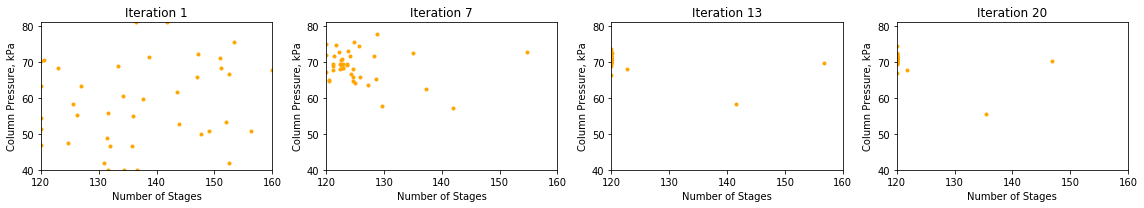

In [34]:
visualizer.view()

**Or we can view it as an animation (currently not implemented for displaying in IPython notebooks)**

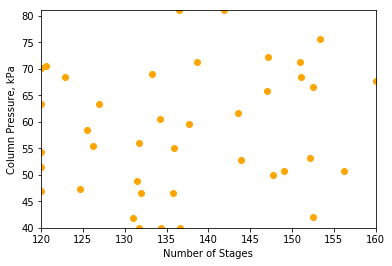

In [35]:
visualizer.view_animation()

**We can also view the lowest cost achieved in each iteration, over time.**

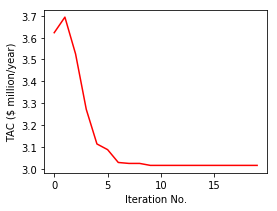

In [36]:
visualizer.view_cost_graph()